## Notebook for the Kong 2023 QC 
### Developed by: Anna Maguza

### Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich

### 4th April 2023

#### Load required packages

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#### Setup Cells

In [ ]:
%matplotlib inline

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


#### Upload Data

In [ ]:
#Loading again to further processing
input_Normal_file = '/Users/anna.maguza/Desktop/Data/Gut_project/Healthy_gut_data/Kong_2023/Raw_anndata/Kong_2023_raw_anndata.h5ad'  # the file that will store the analysis results
output_Normal_file = '/Users/anna.maguza/Desktop/Data/Gut_project/Healthy_gut_data/Kong_2023/Raw_anndata/Kong_2023_raw_anndata_output.h5ad'  # the file that will store the analysis results

In [ ]:
#Anndata upload
adata = sc.read_h5ad(input_Normal_file)
adata.X

<720633x27830 sparse matrix of type '<class 'numpy.float32'>'
	with 729422510 stored elements in Compressed Sparse Row format>

### Explore the dataset


In [ ]:
adata.obs['disease__ontology_label'].value_counts()

Crohn's disease    538827
normal             181806
Name: disease__ontology_label, dtype: int64

In [ ]:
# Filter out only healthy samples
adata = adata[adata.obs['disease__ontology_label'] == 'normal']

In [ ]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)


/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [ ]:
# Make gene_id as a first column in adata.var
adata.var.insert(0, 'gene_id', adata.var.index)

In [ ]:
# Make a gene name as index 
adata.var.index = adata.var['gene_name']

In [ ]:
# Calculate mitochondrial fraction
adata.var['mito'] = adata.var_names.str.startswith(("MT-"))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], percent_top=None, log1p=False, inplace=True)
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

In [ ]:
#Total Counts
sum(adata.obs.total_counts)

721413286.0

In [ ]:
#Mean Genes per Cell
sum(adata.obs.n_genes_by_counts)/401305

457.591819189893

In [ ]:
#Mean Reads per Cell
sum(adata.obs.total_counts)/181806

3968.038931608418

In [ ]:
#Mean percentage of mitochondrial counts
from statistics import mean
mean(adata.obs.pct_counts_mito)

7.780488314788929

In [ ]:
#Mean percentage of ribosomial counts
mean(adata.obs.pct_counts_ribo)

23.270713829365054

#### Quality Parameters Visualization

In [ ]:
#Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

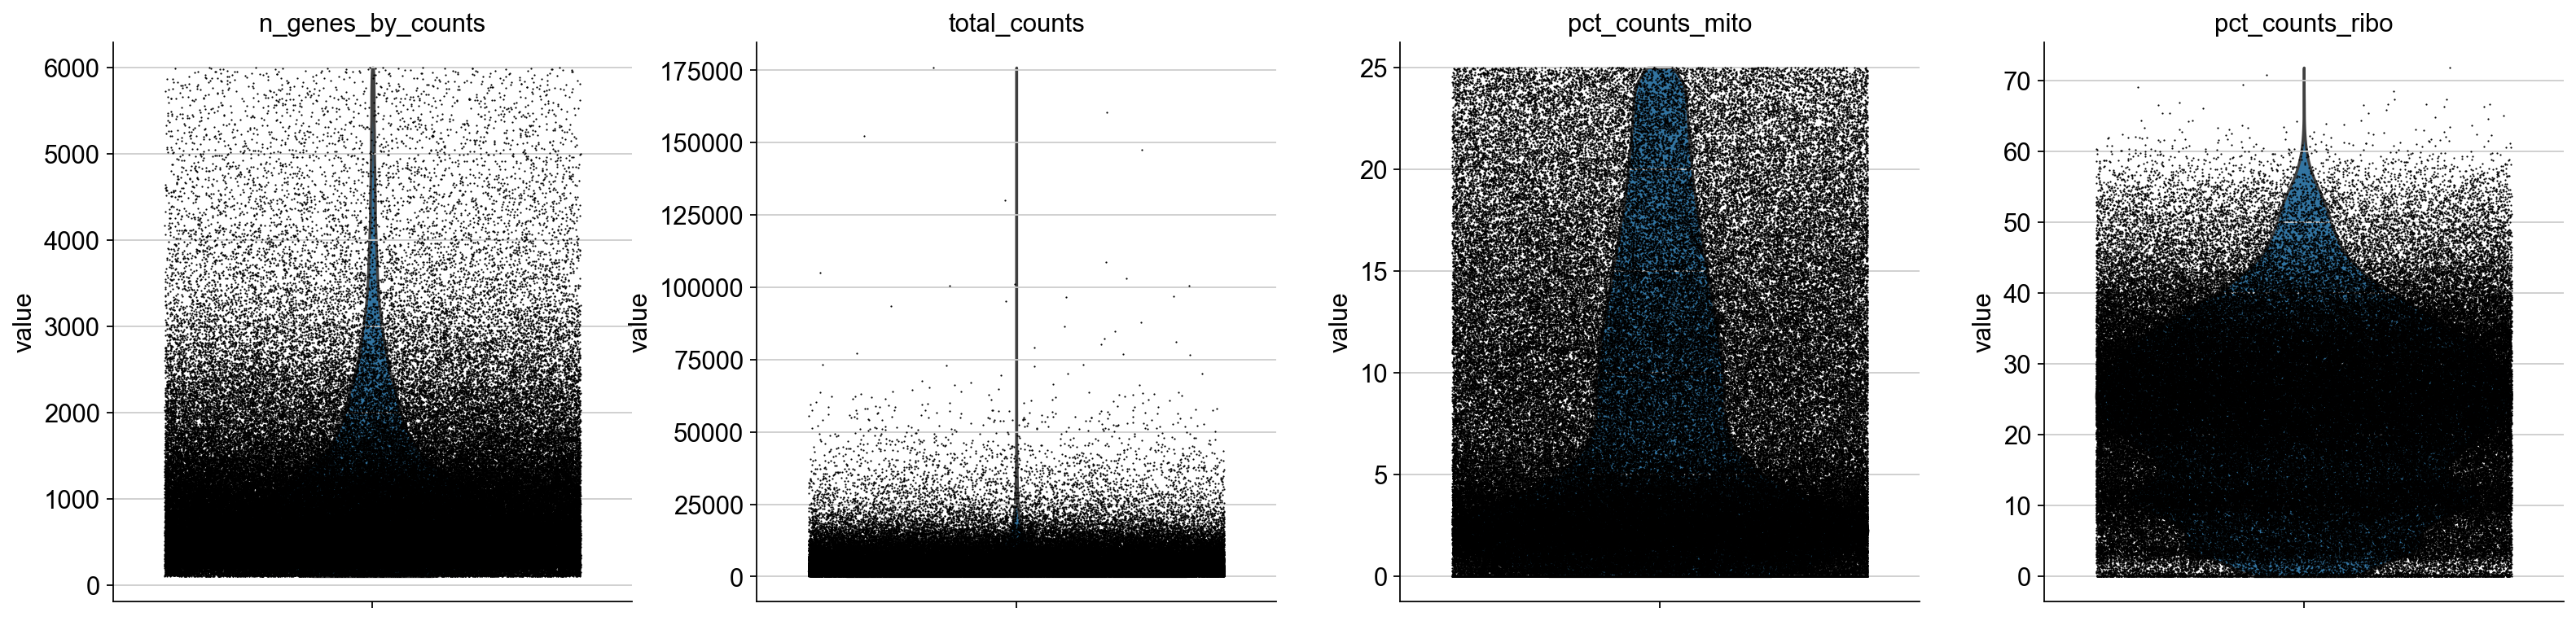

In [ ]:
#A violin plot of some of the computed quality measures:
    # the number of genes expressed in the count matrix
    #the total counts per cell
    #the percentage of counts in mitochondrial genes
    #the percentage of counts in ribosomial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

#### UMAP with QC

In [ ]:
# Copy adata before filtering
adata_raw = adata.copy()

In [ ]:
#Identification of hightly variable genes to run UMAP
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=7000)

In [ ]:
#Neighbors calculating for UMAP
sc.pp.neighbors(adata, n_neighbors = 50, n_pcs = 50)

In [ ]:
#UMAP with QC parameters
sc.tl.umap(adata)

In [ ]:
adata.obs['library_preparation_protocol__ontology_label'].value_counts()

In [ ]:
#UMAP with QC parameters
sc.set_figure_params(figsize=(10, 10),dpi=60)
sc.pl.umap(adata, color_map = "magma", color=['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'cell_type', 'tissue', 'Site', 'Celltype', 'library_preparation_protocol__ontology_label', 'Layer', 'donor_id', 'biosample_id'], use_raw=False, wspace=0.5, save = '_Kong_2023_QC.png')

### Doublets identification

In [ ]:
import scrublet

In [ ]:
scrub = scrublet.Scrublet(adata.X)

Preprocessing...


/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 56.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.2%
Elapsed time: 695.3 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

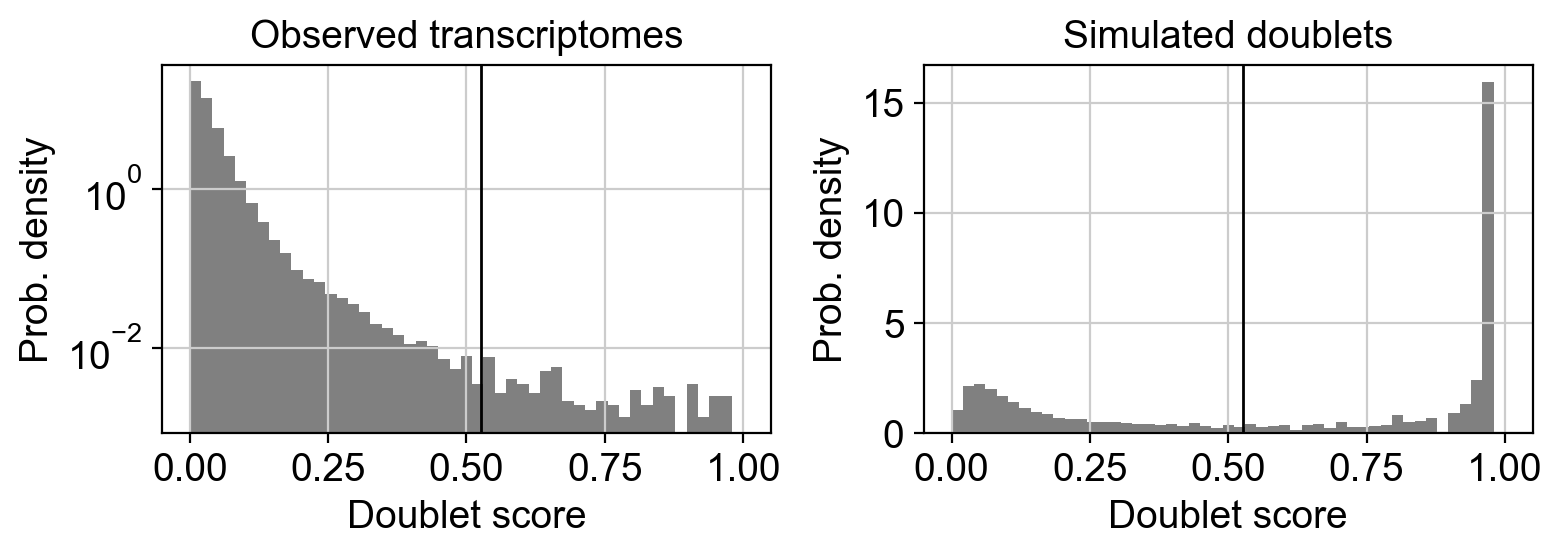

In [ ]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

In [ ]:
sum(adata.obs['predicted_doublets'])

232

In [ ]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

In [ ]:
#check if our predicted doublets also have more detected genes in general
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [ ]:
#Lets run PCA and UMAP and plot doublet scores onto umap to check the doublet predictions.
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=2000)

In [ ]:
adata_scrublet = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata_scrublet, ['total_counts', 'pct_counts_mito'])

In [ ]:
sc.pp.scale(adata_scrublet, max_value=10)

In [ ]:
sc.pp.neighbors(adata_scrublet, n_neighbors = 50, n_pcs = 50)

In [ ]:
sc.tl.umap(adata_scrublet)

In [ ]:
%matplotlib inline
sc.set_figure_params(figsize=(7, 7),dpi=100)
sc.pl.umap(adata_scrublet, color_map = "magma", color=['doublet_scores','doublet_info'])

In [ ]:
del adata_scrublet

In [ ]:
# Remove doublets from adata
adata = adata[adata.obs['predicted_doublets'] == False]

#### Calculate cell cycle scores

In [ ]:
sc.pl.umap(adata, color_map = "magma", color=['EXO1'])

In [ ]:
!if [ ! -f /Users/anna.maguza/Desktop/GCA_social_network/cell_cycle_genes.txt ]; then curl -o /Users/anna.maguza/Desktop/GCA_social_network/cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [ ]:
cell_cycle_genes = [x.strip() for x in open('/Users/anna.maguza/Desktop/GCA_social_network/cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [ ]:
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [ ]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

94


In [ ]:
#Create basic anndata for score calculation
adata_log = an.AnnData(X = adata.X,  var = adata.var, obs = adata.obs)

In [ ]:
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['PARK7', 'PLA2G2A', 'C1QA', 'C1QB', 'ID3', 'RPL11', 'SH3BGRL3', 'CD52', 'GUCA2B', 'GUCA2A', 'YBX1', 'PRDX1', 'UQCRH', 'JUN', 'REG4', 'S100A10', 'S100A6', 'RPS27', 'HAX1', 'RGS5', 'RGS2', 'PIGR', 'RPS27A', 'ACTG2', 'REG1B', 'REG1A', 'REG3A', 'TMSB10', 'GNLY', 'FABP1', 'DUSP2', 'CXCR4', 'GCG', 'ATP5G3', 'SLC40A1', 'CCL20', 'PTMA', 'RPL32', 'RPL15', 'RPL14', 'TKT', 'MTRNR2L12', 'RPL24', 'SERP1', 'APOD', 'RPL9', 'IGFBP7', 'IGJ', 'IL8', 'CXCL10', 'RPL34', 'RPS3A', 'MRPL36', 'GZMA', 'COX7C', 'SKP1', 'CXCL14', 'MZB1', 'CD74', 'RPS14', 'LARP1', 'FABP6', 'NUDCD2', 'DUSP1', 'ZNF165', 'MRPS18B', 'HLA-B', 'AIF1', 'CLIC1', 'HSPA1A', 'RNF5', 'HLA-DRA', 'HLA-DRB5', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1', 'RPS18', 'IL17A', 'EEF1A1', 'SNX3', 'RWDD1', 'CTGF', 'ACTB', 'AGR2', 'CYCS', 'HNRNPA2B1', 'HSPB1', 'NAPEPLD', 'SLC26A3', 'ATP6V1F', 'ZC3HC1', 'TMSB4X', 'SAT1', 'TIMP1', 'SSR4', 'R

In [ ]:
sc.pp.log1p(adata_log)

In [ ]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)

In [ ]:
%matplotlib inline
sc.set_figure_params(figsize=(25, 7),dpi=100)
sc.pl.violin(adata_log, ['S_score'],
             jitter = 0.4, groupby = "biosample_id", rotation = 90)

In [ ]:
%matplotlib inline
sc.set_figure_params(figsize=(25, 7),dpi=100)
sc.pl.violin(adata_log, ['G2M_score'],
             jitter = 0.4, groupby = "biosample_id", rotation = 90)

In [ ]:
adata.obs['S_score'] = adata_log.obs['S_score']
adata.obs['G2M_score'] = adata_log.obs['G2M_score']


In [ ]:
# Save adata
adata.write('/Users/anna.maguza/Desktop/Data/Gut_project/Healthy_gut_data/Kong_2023/Raw_anndata/adata_Kong_2023_healthy_with_QC.h5ad')